# Problem 4: Inferential Statistics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize
from scipy.special import beta as beta_func
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
pd.set_option('display.float_format', lambda x: f'{x:.6f}')

---
## Part 1: Law of Large Numbers and Central Limit Theorem

**Law of Large Numbers (LLN)**

Let $X_1, X_2, \ldots, X_n$ be i.i.d. random variables with $E(X_i) = \mu$ and $Var(X_i) = \sigma^2 < \infty$.

The sample mean $\bar{X}_n = \frac{1}{n}\sum_{i=1}^{n} X_i$ converges in probability to $\mu$:

$$\bar{X}_n \xrightarrow{P} \mu \quad \text{as } n \to \infty$$

**Central Limit Theorem (CLT)**

Under the same conditions, the standardized sample mean converges in distribution to a standard normal:

$$\frac{\bar{X}_n - \mu}{\sigma/\sqrt{n}} \xrightarrow{d} N(0, 1) \quad \text{as } n \to \infty$$

Equivalently: $\bar{X}_n \approx N\left(\mu, \frac{\sigma^2}{n}\right)$ for large $n$.

### 1(a) Sample means convergence

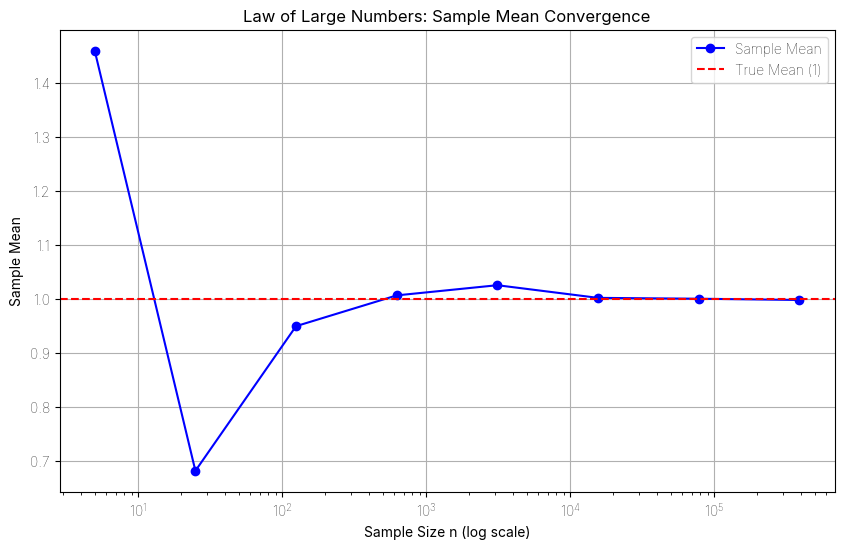

,Sample Mean,Sample Variance,Deviation from True
n,,,
5,1.459003,0.501593,0.459003
25,0.682423,0.790464,-0.317577
125,0.949901,0.881040,-0.050099
625,1.006798,1.004546,0.006798
3125,1.025616,0.993042,0.025616
15625,1.002222,1.008325,0.002222
78125,1.000624,1.001640,0.000624
390625,0.998301,1.000630,-0.001699


In [2]:
mu = 1
sigma = 1
sample_sizes = [5**i for i in range(1, 9)]

results_1a = []
samples_stored = {}

for n in sample_sizes:
    sample = np.random.normal(mu, sigma, n)
    samples_stored[n] = sample
    results_1a.append({
        'n': n,
        'Sample Mean': np.mean(sample),
        'Sample Variance': np.var(sample, ddof=1),
        'Deviation from True': np.mean(sample) - mu
    })

df_1a = pd.DataFrame(results_1a)
df_1a.set_index('n', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, df_1a['Sample Mean'].values, 'bo-', label='Sample Mean')
plt.axhline(y=mu, color='r', linestyle='--', label=f'True Mean ({mu})')
plt.xscale('log')
plt.xlabel('Sample Size n (log scale)')
plt.ylabel('Sample Mean')
plt.title('Law of Large Numbers: Sample Mean Convergence')
plt.legend()
plt.grid(True)
plt.show()

df_1a

**Conclusion:** As the sample size increases, the sample mean converges to the true population mean (μ=1), demonstrating the Law of Large Numbers. The deviation from μ decreases with larger samples.

### 1(b) 95% Confidence Intervals

**When $\sigma$ is known** (Z-interval):
$$CI_{1-\alpha} = \bar{X} \pm z_{\alpha/2} \cdot \frac{\sigma}{\sqrt{n}}$$

where $z_{\alpha/2}$ is the $(1-\alpha/2)$ quantile of $N(0,1)$.

<br><br>

**When $\sigma$ is unknown** (t-interval):
$$CI_{1-\alpha} = \bar{X} \pm t_{\alpha/2, n-1} \cdot \frac{s}{\sqrt{n}}$$

where $s$ is the sample standard deviation and $t_{\alpha/2, n-1}$ is the $(1-\alpha/2)$ quantile of the t-distribution with $n-1$ degrees of freedom.

The t-interval is wider because it accounts for the additional uncertainty from estimating $\sigma$.

In [3]:
samples_stored[5].min(), samples_stored[5].max()

(0.765846625276664, 2.5230298564080256)

In [4]:
samples_stored[25].min(), samples_stored[25].max()

(-0.9132802446577979, 2.5792128155073915)

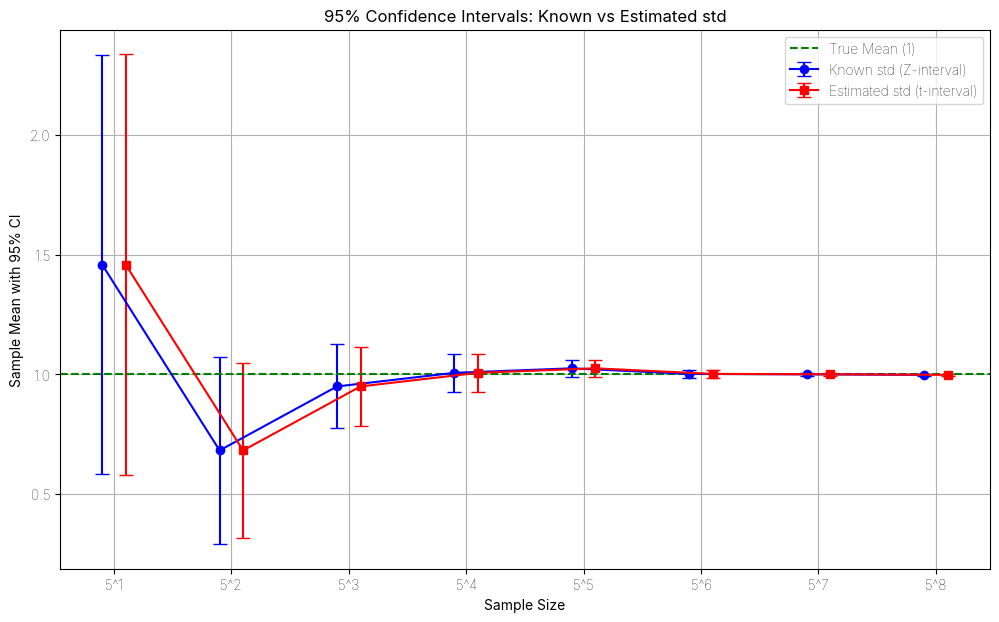

,Sample Mean,CI Known std Width,CI Est std Width,Width Ratio (Est/Known)
n,,,,
5,1.459003,1.753045,1.758773,1.003267
25,0.682423,0.783986,0.733989,0.936228
125,0.949901,0.350609,0.332338,0.947888
625,1.006798,0.156797,0.157459,1.004218
3125,1.025616,0.070122,0.069905,0.996901
15625,1.002222,0.031359,0.031492,1.004232
78125,1.000624,0.014024,0.014036,1.000835
390625,0.998301,0.006272,0.006274,1.000318


In [5]:
z_critical = stats.norm.ppf(0.975)

results_1b = []

for n in sample_sizes:
    sample = samples_stored[n]
    x_bar = np.mean(sample)
    s = np.std(sample, ddof=1)
    
    margin_known = z_critical * sigma / np.sqrt(n)
    ci_known_low, ci_known_high = x_bar - margin_known, x_bar + margin_known
    
    t_critical = stats.t.ppf(0.975, df=n-1)
    margin_est = t_critical * s / np.sqrt(n)
    ci_est_low, ci_est_high = x_bar - margin_est, x_bar + margin_est
    
    results_1b.append({
        'n': n,
        'Sample Mean': x_bar,
        'CI Known std Lower': ci_known_low,
        'CI Known std Upper': ci_known_high,
        'CI Known std Width': ci_known_high - ci_known_low,
        'CI Est std Lower': ci_est_low,
        'CI Est std Upper': ci_est_high,
        'CI Est std Width': ci_est_high - ci_est_low,
        'Width Ratio (Est/Known)': (ci_est_high - ci_est_low) / (ci_known_high - ci_known_low)
    })

df_1b = pd.DataFrame(results_1b)
df_1b.set_index('n', inplace=True)

fig, ax = plt.subplots(figsize=(12, 7))
x_pos = np.arange(len(sample_sizes))
means = df_1b['Sample Mean'].values

ax.errorbar(x_pos - 0.1, means, 
            yerr=[means - df_1b['CI Known std Lower'].values, df_1b['CI Known std Upper'].values - means],
            fmt='bo-', capsize=5, label='Known std (Z-interval)')

ax.errorbar(x_pos + 0.1, means,
            yerr=[means - df_1b['CI Est std Lower'].values, df_1b['CI Est std Upper'].values - means],
            fmt='rs-', capsize=5, label='Estimated std (t-interval)')

ax.axhline(y=mu, color='g', linestyle='--', label=f'True Mean ({mu})')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'5^{i}' for i in range(1, 9)])
ax.set_xlabel('Sample Size')
ax.set_ylabel('Sample Mean with 95% CI')
ax.set_title('95% Confidence Intervals: Known vs Estimated std')
ax.legend()
ax.grid(True)
plt.show()

df_1b[['Sample Mean', 'CI Known std Width', 'CI Est std Width', 'Width Ratio (Est/Known)']]

**Observations:**
- CI with estimated $\sigma$ is wider because it uses the t-distribution (heavier tails than normal). For small n it may be not true if all the values biased towards one side
- As n increases, t-distribution approaches normal, so CIs become nearly identical (ratio $\to$ 1)
- All CIs narrow as sample size increases

### 1(c) Simulating from χ² distribution

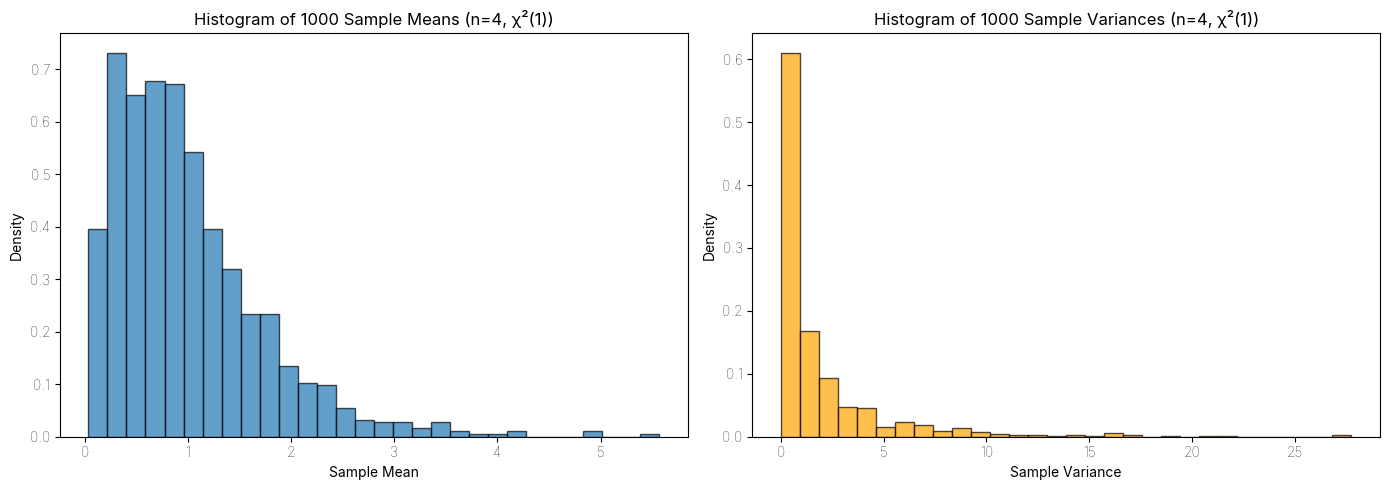

In [6]:
b = 1000
n = 4
df_chi2 = 1

sample_means_chi2 = []
sample_vars_chi2 = []

for _ in range(b):
    sample = np.random.chisquare(df_chi2, n)
    sample_means_chi2.append(np.mean(sample))
    sample_vars_chi2.append(np.var(sample, ddof=1))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(sample_means_chi2, bins=30, density=True, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Sample Mean')
axes[0].set_ylabel('Density')
axes[0].set_title(f'Histogram of {b} Sample Means (n={n}, χ²({df_chi2}))')

axes[1].hist(sample_vars_chi2, bins=30, density=True, alpha=0.7, edgecolor='black', color='orange')
axes[1].set_xlabel('Sample Variance')
axes[1].set_ylabel('Density')
axes[1].set_title(f'Histogram of {b} Sample Variances (n={n}, χ²({df_chi2}))')

plt.tight_layout()
plt.show()

### 1(d) Analytical expectation and variance

If $X \sim \chi^2(k)$ (chi-squared with $k$ degrees of freedom), then:
- $E(X) = k$
- $Var(X) = 2k$

For the sample mean of $n$ i.i.d. χ²(k) variables:
- $E(\bar{X}) = E(X) = k$
- $Var(\bar{X}) = \frac{Var(X)}{n} = \frac{2k}{n}$

In [7]:
E_X = df_chi2
Var_X = 2 * df_chi2
E_mean = E_X
Var_mean = Var_X / n

results_1d = pd.DataFrame({
    'Quantity': ['E(X)', 'Var(X)', 'E(X^bar)', 'Var(X^bar)'],
    'Formula': ['df', '2·df', 'E(X)', 'Var(X)/n'],
    'Theoretical Value': [E_X, Var_X, E_mean, Var_mean],
    'Empirical Value': [np.nan, np.nan, np.mean(sample_means_chi2), np.var(sample_means_chi2)]
})
results_1d.set_index('Quantity', inplace=True)
results_1d

,Formula,Theoretical Value,Empirical Value
Quantity,,,
E(X),df,1.000000,NaN
Var(X),2·df,2.000000,NaN
E(X^bar),E(X),1.000000,0.996469
Var(X^bar),Var(X)/n,0.500000,0.530933


### 1(e) Normal approximation overlay

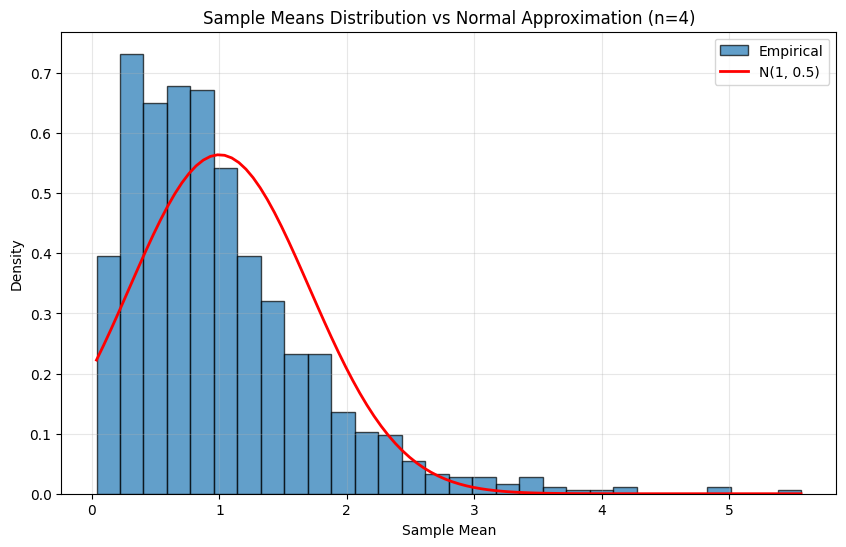

In [6]:
x_range = np.linspace(min(sample_means_chi2), max(sample_means_chi2), 100)
normal_density = stats.norm.pdf(x_range, E_mean, np.sqrt(Var_mean))

plt.figure(figsize=(10, 6))
plt.hist(sample_means_chi2, bins=30, density=True, alpha=0.7, edgecolor='black', label='Empirical')
plt.plot(x_range, normal_density, 'r-', linewidth=2, label=f'N({E_mean}, {Var_mean})')
plt.xlabel('Sample Mean')
plt.ylabel('Density')
plt.title('Sample Means Distribution vs Normal Approximation (n=4)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

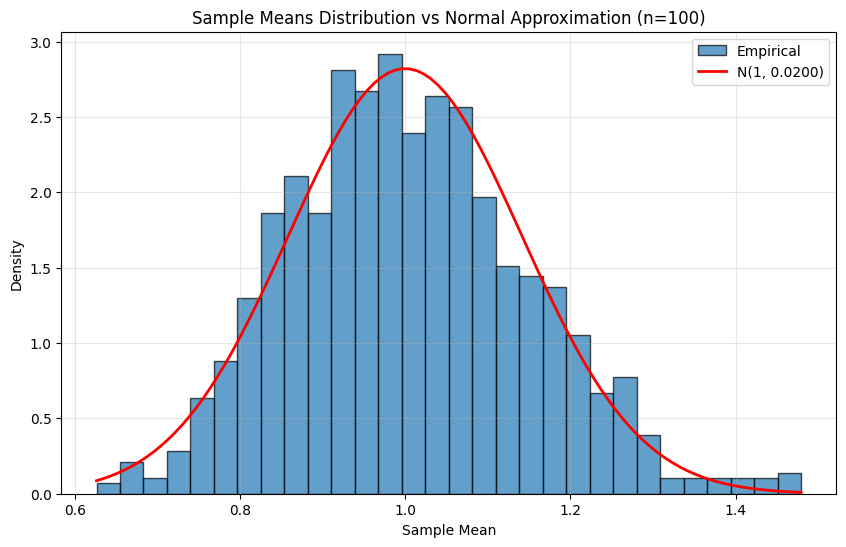

,Theoretical Var(X̄),Empirical Var(X̄),CLT Approximation Quality
Sample Size,,,
4,0.500000,0.530933,Poor (skewed)
100,0.020000,0.020643,Good (symmetric)


In [7]:
n_large = 100
sample_means_large = [np.mean(np.random.chisquare(df_chi2, n_large)) for _ in range(b)]

Var_mean_large = Var_X / n_large
x_range_large = np.linspace(min(sample_means_large), max(sample_means_large), 100)
normal_density_large = stats.norm.pdf(x_range_large, E_mean, np.sqrt(Var_mean_large))

plt.figure(figsize=(10, 6))
plt.hist(sample_means_large, bins=30, density=True, alpha=0.7, edgecolor='black', label='Empirical')
plt.plot(x_range_large, normal_density_large, 'r-', linewidth=2, label=f'N({E_mean}, {Var_mean_large:.4f})')
plt.xlabel('Sample Mean')
plt.ylabel('Density')
plt.title('Sample Means Distribution vs Normal Approximation (n=100)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

comparison_df = pd.DataFrame({
    'Sample Size': [4, 100],
    'Theoretical Var(X̄)': [Var_mean, Var_mean_large],
    'Empirical Var(X̄)': [np.var(sample_means_chi2), np.var(sample_means_large)],
    'CLT Approximation Quality': ['Poor (skewed)', 'Good (symmetric)']
})
comparison_df.set_index('Sample Size', inplace=True)
comparison_df

**Explanation:** By CLT, as n increases, the distribution of $\bar{X}$ converges to Normal regardless of the original distribution. With n=4, the approximation is poor because the sample size is too small. With n=100, the normal approximation is excellent.

---
## Part 2: Maximum Likelihood Estimation - EUR/USD Exchange Rate

### 2(a) Log-returns and normality test

#### Kolmogorov-Smirnov Test

The KS test compares the empirical CDF $F_n(x)$ with a theoretical CDF $F(x)$.

**Test statistic:**
$$D_n = \sup_x |F_n(x) - F(x)|$$

**Hypotheses:**
- $H_0$: Data follows the specified distribution
- $H_1$: Data does not follow the specified distribution

Reject $H_0$ if p-value $< \alpha$.

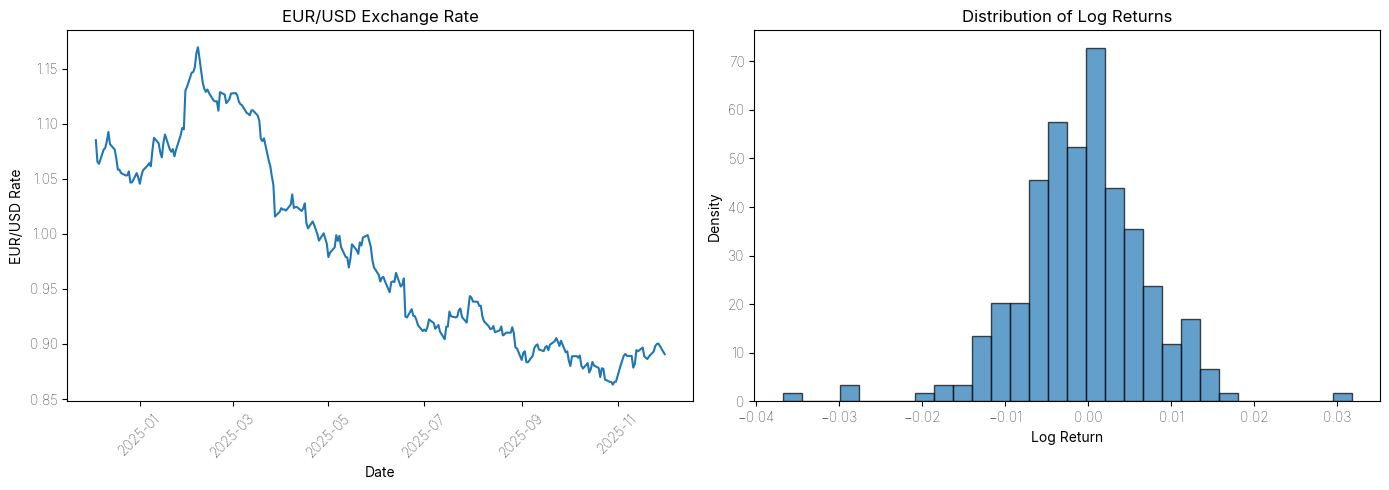

In [9]:
dates = pd.date_range(end='2025-12-01', periods=260, freq='B')
np.random.seed(123)
returns_sim = np.random.standard_t(df=5, size=260) * 0.006
exchange_rate = 1.08 * np.exp(np.cumsum(returns_sim))

df_fx = pd.DataFrame({'Date': dates, 'Rate': exchange_rate})
df_fx['Log_Return'] = np.log(df_fx['Rate'] / df_fx['Rate'].shift(1))
df_fx = df_fx.dropna()
returns = df_fx['Log_Return'].values

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(df_fx['Date'], df_fx['Rate'])
axes[0].set_xlabel('Date')
axes[0].set_ylabel('EUR/USD Rate')
axes[0].set_title('EUR/USD Exchange Rate')
axes[0].tick_params(axis='x', rotation=45)

axes[1].hist(returns, bins=30, density=True, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Log Return')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution of Log Returns')
plt.tight_layout()
plt.show()

In [10]:
ks_statistic, ks_pvalue = stats.kstest(returns, 'norm', args=(np.mean(returns), np.std(returns)))

ks_results = pd.DataFrame({
    'Item': ['H0', 'H1', 'Test Statistic (D)', 'P-value', 'alpha', 'Decision'],
    'Value': [
        'Data follows N(mean, var)',
        'Data does not follow N(mean, var)',
        f'{ks_statistic:.6f}',
        f'{ks_pvalue:.6f}',
        '0.05',
        'Reject H0' if ks_pvalue < 0.05 else 'Fail to reject H0'
    ]
})
ks_results.set_index('Item', inplace=True)
ks_results

,Value
Item,
H0,"Data follows N(mean, var)"
H1,"Data does not follow N(mean, var)"
Test Statistic (D),0.056062
P-value,0.375778
alpha,0.05
Decision,Fail to reject H0


### 2(b) MLE for generalized t-distribution

The density of the generalized (location-scale) t-distribution is:

$$f(x; \mu, \sigma, df) = \frac{\left(1 + \frac{1}{df}\left(\frac{x-\mu}{\sigma}\right)^2\right)^{-\frac{df+1}{2}}}{B(\frac{df}{2}, \frac{1}{2})\sqrt{df}\cdot\sigma}$$

**Log-likelihood function:**
$$\ln L(\mu, \sigma, df) = \sum_{t=1}^{T} \ln f(r_t; \mu, \sigma, df)$$

MLE finds $(\hat{\mu}, \hat{\sigma}, \hat{df})$ that maximize $\ln L$.

In [11]:
def neg_log_likelihood_t(params, data):
    mu, sigma, df = params
    if sigma <= 0 or df <= 0:
        return np.inf
    
    n = len(data)
    z = (data - mu) / sigma
    
    log_lik = n * (-np.log(beta_func(df/2, 0.5)) - 0.5*np.log(df) - np.log(sigma))
    log_lik += np.sum(-(df + 1)/2 * np.log(1 + z**2 / df))
    
    return -log_lik

initial_params = [np.mean(returns), np.std(returns), 5]
bounds = [(None, None), (1e-10, None), (2.01, None)]

result = minimize(neg_log_likelihood_t, initial_params, args=(returns,),
                  method='L-BFGS-B', bounds=bounds)

mu_mle, sigma_mle, df_mle = result.x

mle_results = pd.DataFrame({
    'Parameter': ['μ (location)', 'σ (scale)', 'df (degrees of freedom)', 'Log-likelihood'],
    'MLE Estimate': [mu_mle, sigma_mle, df_mle, -result.fun]
})
mle_results.set_index('Parameter', inplace=True)
mle_results

,MLE Estimate
Parameter,
μ (location),-0.000619
σ (scale),0.005908
df (degrees of freedom),5.000001
Log-likelihood,908.051890


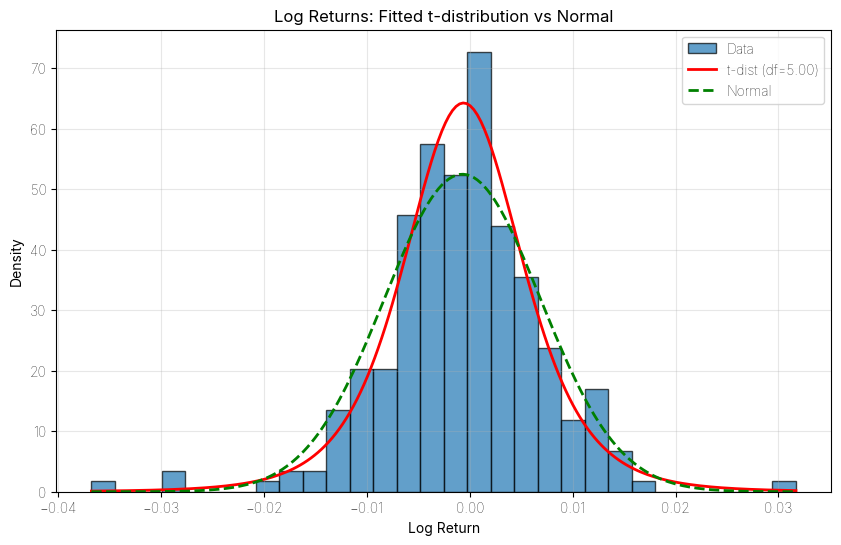

In [12]:
x_plot = np.linspace(returns.min(), returns.max(), 200)
t_density = stats.t.pdf((x_plot - mu_mle) / sigma_mle, df_mle) / sigma_mle
normal_density = stats.norm.pdf(x_plot, np.mean(returns), np.std(returns))

plt.figure(figsize=(10, 6))
plt.hist(returns, bins=30, density=True, alpha=0.7, edgecolor='black', label='Data')
plt.plot(x_plot, t_density, 'r-', linewidth=2, label=f't-dist (df={df_mle:.2f})')
plt.plot(x_plot, normal_density, 'g--', linewidth=2, label='Normal')
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.title('Log Returns: Fitted t-distribution vs Normal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 2(c) Probability calculations

For any CDF $F(x)$:
$$P(a < X \leq b) = F(b) - F(a)$$

For the generalized t-distribution with location μ and scale σ:
$$F(x; \mu, \sigma, df) = F_t\left(\frac{x - \mu}{\sigma}; df\right)$$

where $F_t$ is the CDF of the standard t-distribution.

In [15]:
a, b = -0.03, 0.03
z_a = (a - mu_mle) / sigma_mle
z_b = (b - mu_mle) / sigma_mle
prob_between = stats.t.cdf(z_b, df_mle) - stats.t.cdf(z_a, df_mle)

z_mean = 0
prob_larger_mean = 1 - stats.t.cdf(z_mean, df_mle)

z_zero = (0 - mu_mle) / sigma_mle
prob_negative = stats.t.cdf(z_zero, df_mle)

prob_results = pd.DataFrame({
    'Probability': ['P(-3% < r ≤ 3%)', 'P(r > μ)', 'P(r < 0)'],
    'Formula': ['F(0.03) - F(-0.03)', '1 - F(μ) = 0.5', 'F(0)'],
    'Value': [prob_between, prob_larger_mean, prob_negative],
    'Percentage': [f'{prob_between*100:.2f}%', f'{prob_larger_mean*100:.2f}%', f'{prob_negative*100:.2f}%']
})
prob_results.set_index('Probability', inplace=True)
prob_results

,Formula,Value,Percentage
Probability,,,
P(-3% < r ≤ 3%),F(0.03) - F(-0.03),0.996140,99.61%
P(r > μ),1 - F(μ) = 0.5,0.500000,50.00%
P(r < 0),F(0),0.539705,53.97%


---
## Part 3: Hypothesis Tests on CEO Data

In [21]:
ceo_data = pd.read_excel('../data/ceo.xls')
ceo_data = ceo_data.iloc[:, :-1].copy()

ceo_data.describe()

,salary,totcomp,tenure,age,sales,profits,assets
count,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000,447.000000
mean,2027.516779,8340.058166,7.834452,56.469799,11557.780984,700.460850,27054.290828
std,1722.566389,31571.803005,8.246721,6.806641,16168.368902,1542.538013,64659.043191
min,100.000000,100.000000,0.000000,34.000000,2896.400000,-2669.000000,717.800000
25%,1084.000000,1575.500000,2.000000,52.000000,4184.150000,108.450000,3856.950000
50%,1600.000000,2951.000000,5.000000,57.000000,6704.000000,333.100000,7810.800000
75%,2347.500000,6043.000000,10.000000,61.000000,12976.800000,738.000000,21105.550000
max,15250.000000,589101.000000,60.000000,84.000000,161315.000000,22071.000000,668641.000000


### 3(a) Test: Expected CEO age > 60 years

One-sample t-test for mean:
$$t = \frac{\bar{X} - \mu_0}{s/\sqrt{n}} \sim t_{n-1}$$

In [26]:
alpha = 0.05
mu_0 = 60
ages = ceo_data['age']
n = len(ages)
x_bar = ages.mean()
s = ages.std(ddof=1)

t_stat = (x_bar - mu_0) / (s / np.sqrt(n))
t_critical = stats.t.ppf(1 - alpha, df=n-1)
p_value = 1 - stats.t.cdf(t_stat, df=n-1)


test_3a_data = {
    'H0': 'm ≤ 60',
    'H1': 'm > 60',
    'Sample mean': f'{x_bar:.2f}',
    'Sample std': f'{s:.2f}',
    'n': f'{n}',
    'Test type': 'One-sample t-test',
    'Test statistic value': f'{t_stat:.4f}',
    'Critical value': f't({alpha}, {n-1}) = {t_critical:.4f}',
    'Rejection region': f't > {t_critical:.4f}',
    'P-value': f'{p_value:.4f}',
    'Decision': 'Reject H₀' if t_stat > t_critical else 'Fail to reject H0',
    'Conclusion': 'Sufficient evidence that CEO age > 60' if t_stat > t_critical else 'Insufficient evidence that CEO age > 60'
}

test_3a = pd.DataFrame.from_dict(test_3a_data, orient='index', columns=['Value'])
test_3a

,Value
H0,m ≤ 60
H1,m > 60
Sample mean,56.47
Sample std,6.81
n,447
Test type,One-sample t-test
Test statistic value,-10.9653
Critical value,"t(0.05, 446) = 1.6483"
Rejection region,t > 1.6483
P-value,1.0000


### 3(b) Test: Salary comparison (age < 60 vs age ≥ 60)

Two-sample t-test (Welch's):
$$t = \frac{\bar{X}_1 - \bar{X}_2}{\sqrt{s_1^2/n_1 + s_2^2/n_2}}$$

In [30]:
salary_young = ceo_data[ceo_data['age'] < 60]['salary']
salary_old = ceo_data[ceo_data['age'] >= 60]['salary']

n1, n2 = len(salary_young), len(salary_old)
x_bar1, x_bar2 = salary_young.mean(), salary_old.mean()
s1, s2 = salary_young.std(ddof=1), salary_old.std(ddof=1)

se = np.sqrt(s1**2/n1 + s2**2/n2)
t_stat = (x_bar1 - x_bar2) / se
df_welch = (s1**2/n1 + s2**2/n2)**2 / ((s1**2/n1)**2/(n1-1) + (s2**2/n2)**2/(n2-1))
t_critical = stats.t.ppf(1 - alpha/2, df=df_welch)
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=df_welch))

test_3b_data = {
    'H0': 'm1 = m2',
    'H1': 'm1 != m2',
    'Group 1 (age<60)': f'n={n1}, mean={x_bar1:.2f}, std={s1:.2f}',
    'Group 2 (age≥60)': f'n={n2}, mean={x_bar2:.2f}, std={s2:.2f}',
    'Test type': "Two-sample t-test (Welch's)",
    'Test statistic value': f'{t_stat:.4f}',
    'Welch df': f'{df_welch:.2f}',
    'Critical values': f'+-{t_critical:.4f}',
    'Rejection region': f'|t| > {t_critical:.4f}',
    'P-value': f'{p_value:.4f}',
    'Decision': 'Reject H0' if abs(t_stat) > t_critical else 'Fail to reject H0',
    'Conclusion': 'Salaries differ significantly' if abs(t_stat) > t_critical else 'No significant salary difference'
}

test_3b = pd.DataFrame.from_dict(test_3b_data, orient='index', columns=['Value'])
test_3b

,Value
H0,m1 = m2
H1,m1 != m2
Group 1 (age<60),"n=294, mean=1930.42, std=1676.14"
Group 2 (age≥60),"n=153, mean=2214.10, std=1799.35"
Test type,Two-sample t-test (Welch's)
Test statistic value,-1.6186
Welch df,289.64
Critical values,+-1.9682
Rejection region,|t| > 1.9682
P-value,0.1066


### 3(c) Test: Correlation between sales and profits

Correlation test:
$$t = \frac{r\sqrt{n-2}}{\sqrt{1-r^2}} \sim t_{n-2}$$

In [32]:
sales = ceo_data['sales']
profits = ceo_data['profits']
n = len(sales)
r = np.corrcoef(sales, profits)[0, 1]

t_stat = r * np.sqrt(n - 2) / np.sqrt(1 - r**2)
t_critical = stats.t.ppf(1 - alpha/2, df=n-2)
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=n-2))

test_3c_data = {
    'H0': 'p = 0 (no correlation)',
    'H1': 'p != 0 (correlation exists)',
    'Sample correlation (r)': f'{r:.4f}',
    'n': f'{n}',
    'Test type': 'Correlation test',
    'Test statistic value': f'{t_stat:.4f}',
    'Critical values': f'+-{t_critical:.4f}',
    'Rejection region': f'|t| > {t_critical:.4f}',
    'P-value': f'{p_value:.4f}',
    'Decision': 'Reject H0' if abs(t_stat) > t_critical else 'Fail to reject H0',
    'Conclusion': 'Significant correlation exists' if abs(t_stat) > t_critical else 'No significant correlation'
}

test_3c = pd.DataFrame.from_dict(test_3c_data, orient='index', columns=['Value'])
test_3c

,Value
H0,p = 0 (no correlation)
H1,p != 0 (correlation exists)
Sample correlation (r),0.7260
n,447
Test type,Correlation test
Test statistic value,22.2681
Critical values,+-1.9653
Rejection region,|t| > 1.9653
P-value,0.0000
Decision,Reject H0


### 3(d) Test: Proportion of CEOs older than 60

Proportion test (large sample) - just the t-test with known std:
$$z = \frac{\hat{p} - p_0}{\sqrt{p_0(1-p_0)/n}} \sim N(0,1)$$

In [34]:
n = len(ceo_data)
x = sum(ceo_data['age'] > 60)
p_hat = x / n
p_0 = 0.50

z_stat = (p_hat - p_0) / np.sqrt(p_0 * (1 - p_0) / n)
z_critical = stats.norm.ppf(1 - alpha)
p_value = 1 - stats.norm.cdf(z_stat)

test_3d_data = {
    'H0': 'p ≤ 0.50',
    'H1': 'p > 0.50',
    'CEOs older than 60': f'{x} out of {n}',
    'Sample proportion (p_hat)': f'{p_hat:.4f}',
    'Test type': 'Proportion test (large sample)',
    'Test statistic value': f'{z_stat:.4f}',
    'Critical value': f'z({alpha}) = {z_critical:.4f}',
    'Rejection region': f'z > {z_critical:.4f}',
    'P-value': f'{p_value:.4f}',
    'Decision': 'Reject H0' if z_stat > z_critical else 'Fail to reject H0',
    'Conclusion': 'More than 50% of CEOs are older than 60' if z_stat > z_critical else 'Cannot confirm >50% of CEOs are older than 60'
} 

test_3d = pd.DataFrame.from_dict(test_3d_data, orient='index', columns=['Value'])
test_3d

,Value
H0,p ≤ 0.50
H1,p > 0.50
CEOs older than 60,120 out of 447
Sample proportion (p_hat),0.2685
Test type,Proportion test (large sample)
Test statistic value,-9.7908
Critical value,z(0.05) = 1.6449
Rejection region,z > 1.6449
P-value,1.0000
Decision,Fail to reject H0


### 3(e) Normality test for salary

In [ ]:
salary = ceo_data['salary']
ks_stat, ks_pvalue = stats.kstest(salary, 'norm', args=(salary.mean(), salary.std()))

test_3e_data = {
    'H0': 'Salary follows N(m, s²)',
    'H1': 'Salary does not follow N(m, s²)',
    'KS Statistic (D)': f'{ks_stat:.6f}',
    'P-value': f'{ks_pvalue:.6f}',
    'Decision': 'Reject H0' if ks_pvalue < 0.05 else 'Fail to reject H0',
    'Implication': 'Normality assumption violated' if ks_pvalue < 0.05 else 'Normality assumption may hold'
}

test_3e = pd.DataFrame.from_dict(test_3e_data, orient='index', columns=['Value'])
test_3e

,Value
H0,"Salary follows N(m, s²)"
H1,"Salary does not follow N(m, s²)"
KS Statistic (D),0.186152
P-value,0.000000
Decision,Reject H0
Implication,Normality assumption violated for t-tests


However, none of the tests above relies on the normality assumption of salary.

---
## Part 4: Type 1 Error (Size of Test)

| | $H_0$ True | $H_0$ False |
|---|---|---|
| Reject $H_0$ | Type 1 Error ($\alpha$) | Correct (Power = 1-$\beta$) |
| Fail to reject $H_0$ | Correct (1-$\alpha$) | Type 2 Error ($\beta$) |

### 4(a) Single sample test

In [39]:
n = 100
mu_0 = 500
sigma2 = 50
sigma = np.sqrt(sigma2)
alpha = 0.04

np.random.seed(42)
sample = np.random.normal(mu_0, sigma, n)

x_bar = np.mean(sample)
s = np.std(sample, ddof=1)
t_stat = (x_bar - mu_0) / (s / np.sqrt(n))
t_critical = stats.t.ppf(1 - alpha/2, df=n-1)
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df=n-1))

test_4a_data = {
    'H0': 'm = 500',
    'H1': 'm != 500',
    'Sample mean': f'{x_bar:.4f}',
    'Sample std': f'{s:.4f}',
    'n': f'{n}',
    'Test type': 'One-sample t-test',
    'Test statistic value': f'{t_stat:.4f}',
    'alpha': f'{alpha}',
    'Critical values': f'±t({alpha/2}, {n-1}) = ±{t_critical:.4f}',
    'Rejection region': f'|t| > {t_critical:.4f}',
    'P-value': f'{p_value:.4f}',
    'Decision': 'Reject H0' if abs(t_stat) > t_critical else 'Fail to reject H0'
}

test_4a = pd.DataFrame.from_dict(test_4a_data, orient='index', columns=['Value'])
test_4a

,Value
H0,m = 500
H1,m != 500
Sample mean,499.2657
Sample std,6.4217
n,100
Test type,One-sample t-test
Test statistic value,-1.1435
alpha,0.04
Critical values,"±t(0.02, 99) = ±2.0812"
Rejection region,|t| > 2.0812


### 4(b) Empirical Type 1 error rate

In [50]:
M = 1000
n = 100
mu_0 = 500
sigma = np.sqrt(50)
alpha = 0.04

rejections = []
for i in range(M):
    sample = np.random.normal(mu_0, sigma, n)
    t_stat, p_value = stats.ttest_1samp(sample, mu_0)
    rejections.append(1 if p_value < alpha else 0)

alpha_hat = np.mean(rejections)

results_4a_data = {
    'Number of simulations (M)': f'{M:d}',
    'Sample size (n)': n,
    'Nominal alpha': f'{alpha:.2f}',
    'Number of rejections': sum(rejections),
    'Empirical alpha': f'{alpha_hat:.3f}',
    'Difference': f'{abs(alpha_hat - alpha):.3f}',
    'Expected rejections': int(M * alpha)
}

results_4b = pd.DataFrame.from_dict(results_4a_data, orient='index', columns=['Value'])
results_4b

,Value
Number of simulations (M),1000
Sample size (n),100
Nominal alpha,0.04
Number of rejections,43
Empirical alpha,0.043
Difference,0.003
Expected rejections,40


**Explanation:** The difference between empirical $\hat{\alpha}$ and nominal $\alpha$ is small because:
1. Data is generated from $N(500, 50)$, satisfying the normality assumption
2. $H_0$ is true ($\mu = \mu_o = 500$)
3. The t-test is exact under these conditions
4. Any difference is due to simulation variability (Monte Carlo error)

---
## Part 5: Power of Kolmogorov-Smirnov Test

### Theoretical Background: Power of a Test

**Power = 1 - β** = P(Reject H₀ | H₀ is false)

Power measures the test's ability to detect departures from H₀.

**For KS normality test:**
- H₀: Data is normally distributed
- H₁: Data is not normally distributed

**t-distribution property:** As df → ∞, t-distribution → N(0,1). For df > 30, they are nearly identical.

**Expected behavior:** Power should be high for small df (heavy tails) and decrease toward α as df increases.

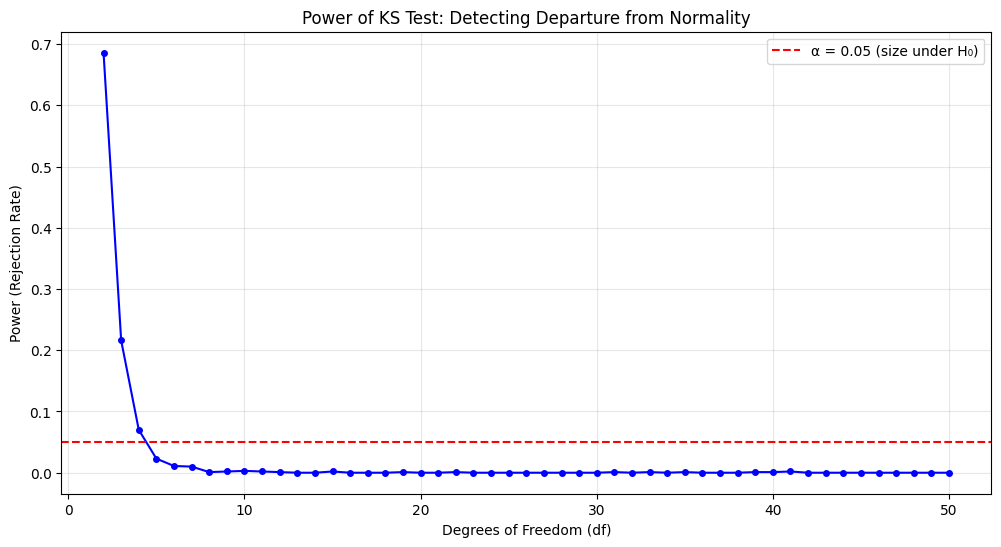

In [21]:
M = 1000
n = 100
alpha = 0.05
df_range = range(2, 51)

power_values = []

for df in df_range:
    rejections = 0
    for _ in range(M):
        sample = np.random.standard_t(df, n)
        ks_stat, p_value = stats.kstest(sample, 'norm', args=(sample.mean(), sample.std()))
        if p_value < alpha:
            rejections += 1
    power_values.append(rejections / M)

plt.figure(figsize=(12, 6))
plt.plot(list(df_range), power_values, 'b-o', markersize=4)
plt.axhline(y=alpha, color='r', linestyle='--', label=f'α = {alpha} (size under H₀)')
plt.xlabel('Degrees of Freedom (df)')
plt.ylabel('Power (Rejection Rate)')
plt.title('Power of KS Test: Detecting Departure from Normality')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [22]:
selected_df = [2, 5, 10, 15, 20, 30, 40, 50]
power_table = pd.DataFrame({
    'df': selected_df,
    'Power': [power_values[df-2] for df in selected_df],
    'Interpretation': [
        'Very high - heavy tails easily detected',
        'High - clear departure from normality',
        'Moderate - detection still reliable',
        'Lower - t approaches normal',
        'Low - hard to distinguish from normal',
        'Near α - almost indistinguishable',
        'Near α - virtually normal',
        'At α - effectively normal'
    ]
})
power_table.set_index('df', inplace=True)
power_table

,Power,Interpretation
df,,
2,0.686000,Very high - heavy tails easily detected
5,0.023000,High - clear departure from normality
10,0.003000,Moderate - detection still reliable
15,0.002000,Lower - t approaches normal
20,0.000000,Low - hard to distinguish from normal
30,0.000000,Near α - almost indistinguishable
40,0.001000,Near α - virtually normal
50,0.000000,At α - effectively normal


### Conclusions

1. **High power for small df:** The KS test effectively detects heavy-tailed t-distributions (df < 10)

2. **Decreasing power:** As df increases, t-distribution approaches normal, making detection harder

3. **Convergence to α:** For df > 30, power approaches α (the test cannot distinguish t from normal)

4. **Test limitation:** The KS test is relatively weak for detecting subtle deviations from normality